## LOAD DATA

In [ ]:
import pandas as pd

data = pd.read_csv("retail_UK.csv")

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], errors='coerce')

## SPLIT DATA

In [ ]:
test_start_date = '2010-04-01'
test_data = data[data['InvoiceDate'] >= test_start_date]
data = data[data['InvoiceDate'] < test_start_date]

print(f"Jumlah data lama: {data.shape[0]}")
print(f"Jumlah data baru: {test_data.shape[0]}")

Jumlah data lama: 95203
Jumlah data baru: 31402


## EDA

In [ ]:
data.info()

data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 95203 entries, 0 to 95202
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      95203 non-null  object        
 1   StockCode    95203 non-null  object        
 2   Description  94219 non-null  object        
 3   Quantity     95203 non-null  int64         
 4   InvoiceDate  95203 non-null  datetime64[ns]
 5   Price        95203 non-null  float64       
 6   Customer ID  72425 non-null  float64       
 7   Country      95203 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 6.5+ MB


,Quantity,InvoiceDate,Price,Customer ID
count,95203.000000,95203,95203.000000,72425.000000
mean,8.863145,2010-02-18 21:25:19.508208896,4.888973,15473.184398
min,-5200.000000,2010-01-04 09:24:00,0.000000,12346.000000
25%,1.000000,2010-01-26 16:19:00,1.250000,14085.000000
50%,3.000000,2010-02-19 12:07:00,2.100000,15421.000000
75%,9.000000,2010-03-12 11:19:00,4.240000,16918.000000
max,10000.000000,2010-03-31 17:53:00,10953.500000,18285.000000
std,83.252855,NaN,88.634639,1600.152062


### Hapus invoice yang dibatalkan

In [ ]:
data['Cancelled'] = data['Invoice'].apply(lambda x: 1 if str(x).startswith('C') else 0)
print(f"Proportion of cancelled transactions: {data['Cancelled'].mean() * 100:.2f}%")

cancelled_per_customer = data.groupby('Customer ID')['Cancelled'].sum()

data['TotalCancelled'] = data['Customer ID'].map(cancelled_per_customer)

Proportion of cancelled transactions: 1.89%


### Hapus data null dan kolom yang tidak diperlukan

In [ ]:
data.dropna(inplace=True)
data.drop(['StockCode', 'Country', 'Description'], axis=1, inplace=True)
print(f"Jumlah data setelah di drop: {data.shape[0]}")

Jumlah data setelah di drop: 72425


### Menambahkan kolom baru yang diperlukan

In [ ]:
data['TotalPrice'] = data['Quantity'] * data['Price']

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data['InvoiceMonth'] = data['InvoiceDate'].dt.month

In [ ]:
data.head()

,Invoice,Quantity,InvoiceDate,Price,Customer ID,Cancelled,TotalCancelled,TotalPrice,InvoiceMonth
0,493410,5,2010-01-04 09:24:00,4.50,12346.0,0,1.0,22.50,1
1,C493411,-1,2010-01-04 09:43:00,4.25,14590.0,1,7.0,-4.25,1
2,493412,5,2010-01-04 09:53:00,4.50,12346.0,0,1.0,22.50,1
6,493414,36,2010-01-04 10:28:00,2.55,14590.0,0,7.0,91.80,1
7,493414,12,2010-01-04 10:28:00,4.25,14590.0,0,7.0,51.00,1


### Cek Jumlah data setelah di drop

In [ ]:
print(f"Jumlah data lama: {data.shape[0]}")
print(f"Jumlah data baru: {test_data.shape[0]}")

Jumlah data lama: 72425
Jumlah data baru: 31402


### Persebaran Quality dan Total Price sebelum cleaning outlier

Boxplot Sebelum Menghapus Outliers:


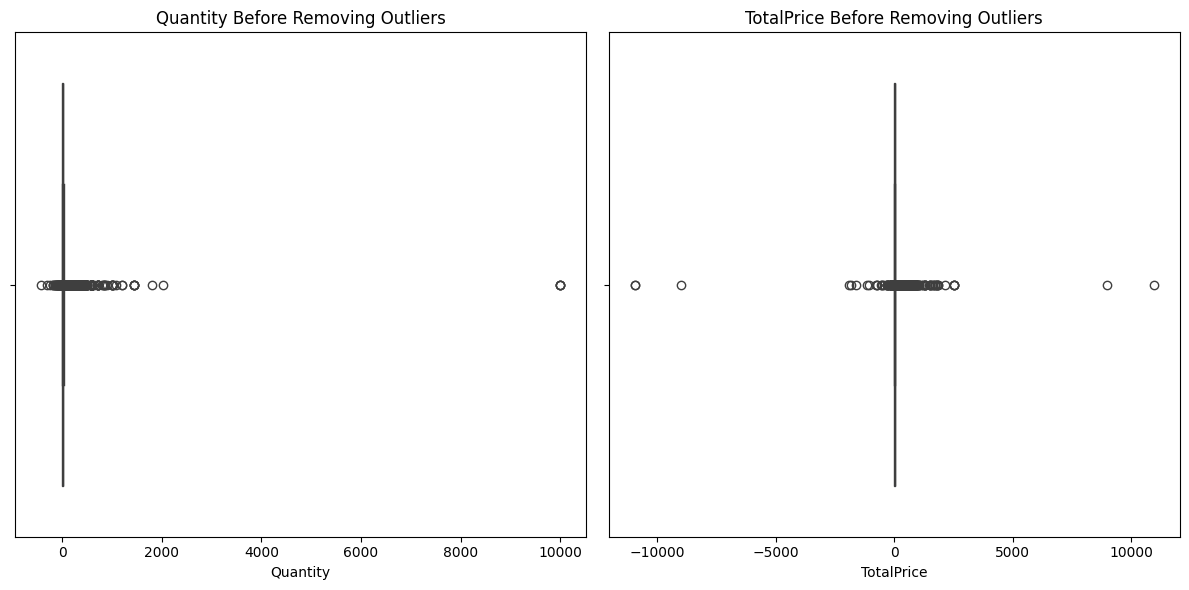

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplot(data, column, ax, title):
    sns.boxplot(x=data[column], ax=ax)
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

print("Boxplot Sebelum Menghapus Outliers:")
plot_boxplot(data, 'Quantity', axes[0], 'Quantity Before Removing Outliers')
plot_boxplot(data, 'TotalPrice', axes[1], 'TotalPrice Before Removing Outliers')

plt.tight_layout()
plt.show()

## Hapus Outlier

In [ ]:
from scipy.stats import zscore

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

data = remove_outliers(data, 'Quantity')
data = remove_outliers(data, 'TotalPrice')
print(f"Data shape after removing outliers: {data.shape}")

Data shape after removing outliers: (64635, 9)


### Persebaran Quality dan Total Price setelah hapus outlier

Boxplot Setelah Menghapus Outliers:


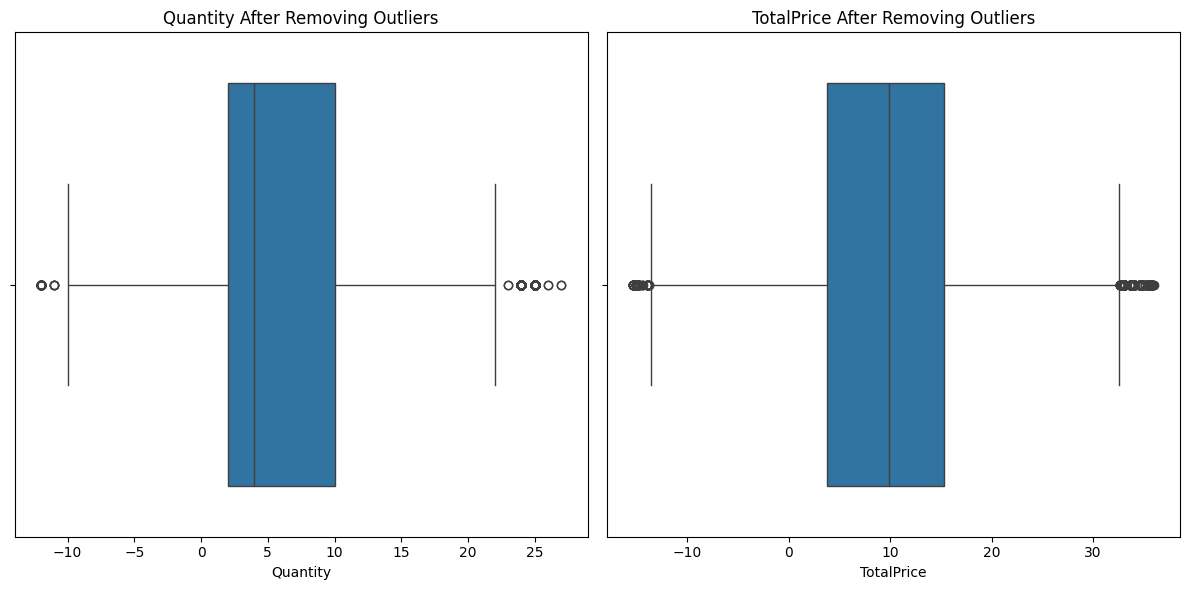

In [ ]:
print("Boxplot Setelah Menghapus Outliers:")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_boxplot(data, 'Quantity', axes[0], 'Quantity After Removing Outliers')
plot_boxplot(data, 'TotalPrice', axes[1], 'TotalPrice After Removing Outliers')
plt.tight_layout()
plt.show()

### Buat Kolom Churn

In [ ]:
last_invoice_date = data['InvoiceDate'].max()
churn_threshold_date = last_invoice_date - pd.DateOffset(months=1)

churn_customers = data.groupby('Customer ID')['InvoiceDate'].max()
data['Churn'] = data['Customer ID'].apply(lambda x: 1 if churn_customers[x] < churn_threshold_date else 0)

In [ ]:
data

,Invoice,Quantity,InvoiceDate,Price,Customer ID,Cancelled,TotalCancelled,TotalPrice,InvoiceMonth,Churn
0,493410,5,2010-01-04 09:24:00,4.50,12346.0,0,1.0,22.50,1,0
1,C493411,-1,2010-01-04 09:43:00,4.25,14590.0,1,7.0,-4.25,1,0
2,493412,5,2010-01-04 09:53:00,4.50,12346.0,0,1.0,22.50,1,0
8,493414,2,2010-01-04 10:28:00,2.55,14590.0,0,7.0,5.10,1,0
9,493414,2,2010-01-04 10:28:00,4.25,14590.0,0,7.0,8.50,1,0
...,...,...,...,...,...,...,...,...,...,...
94995,503427,2,2010-03-31 17:29:00,2.55,13576.0,0,0.0,5.10,3,0
94996,503427,2,2010-03-31 17:29:00,2.55,13576.0,0,0.0,5.10,3,0
94997,503427,2,2010-03-31 17:29:00,2.55,13576.0,0,0.0,5.10,3,0
94998,503427,1,2010-03-31 17:29:00,6.75,13576.0,0,0.0,6.75,3,0


## Memilih fitur yang akan masuk ke model

In [ ]:
from sklearn.model_selection import train_test_split

features = ['Quantity', 'Price', 'TotalPrice', 'InvoiceMonth', 'TotalCancelled']
X = data[features]
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Distribusi kelas pada y_train setelah split:\n", y_train.value_counts())
print("Distribusi kelas pada y_test setelah split:\n", y_test.value_counts())

Distribusi kelas pada y_train setelah split:
 Churn
0    37542
1    14166
Name: count, dtype: int64
Distribusi kelas pada y_test setelah split:
 Churn
0    9386
1    3541
Name: count, dtype: int64


##Hyperparameter tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
import numpy as np

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

rf_model = grid_search.best_estimator_

accuracy = rf_model.score(X_test, y_test)
print("Akurasi terbaik pada data test:", accuracy)
print("Hyperparameter terbaik:", grid_search.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Akurasi terbaik pada data test: 0.8211308170380476
Hyperparameter terbaik: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 50}


### Evaluasi Model

In [ ]:
y_pred = rf_model.predict(X_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Evaluasi Model Random Forest setelah Oversampling dengan SMOTE:")
print("Akurasi    :", accuracy)
print("Precision :", precision)
print("Recall    :", recall)
print("F1 Score  :", f1)

conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Evaluasi Model Random Forest setelah Oversampling dengan SMOTE:
Akurasi    : 0.8211308170380476
Precision : 0.8375969429501481
Recall    : 0.8211308170380476
F1 Score  : 0.8260737134396893

Confusion Matrix:
 [[7926 1590]
 [ 770 2908]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87      9516
           1       0.65      0.79      0.71      3678

    accuracy                           0.82     13194
   macro avg       0.78      0.81      0.79     13194
weighted avg       0.84      0.82      0.83     13194



### Atribut Penting Model Random Forest

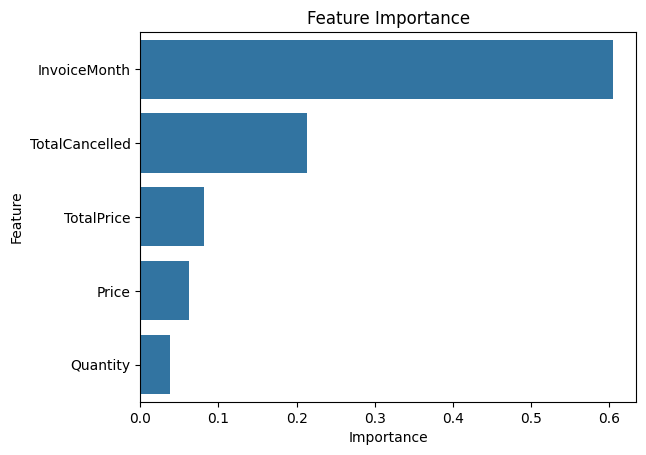

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = rf_model.feature_importances_
features_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

sns.barplot(x='Importance', y='Feature', data=features_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

### Tabel Menunjukkan hasil prediksi

In [ ]:
import pandas as pd

X_test['CustomerID'] = data.loc[X_test.index, 'Customer ID']
X_test['Actual Churn'] = y_test
X_test['Predicted Churn'] = y_pred

X_test[['CustomerID', 'Actual Churn', 'Predicted Churn']].head(10)

,CustomerID,Actual Churn,Predicted Churn
88808,15570.0,0,0
36232,16082.0,1,1
34379,14030.0,1,1
34935,16147.0,1,1
33799,17138.0,0,1
85400,17841.0,0,0
77965,17848.0,0,0
75736,17690.0,0,0
47896,13191.0,1,1
85405,17841.0,0,0


### Evaluasi Confusion Matrix

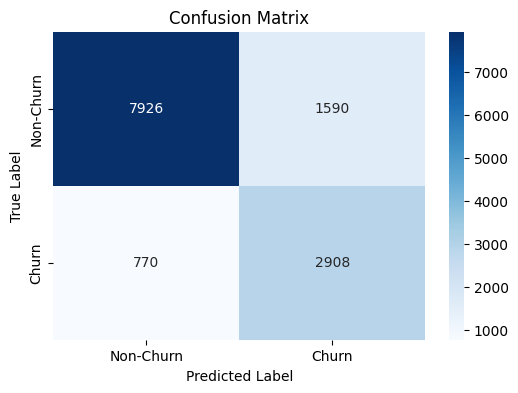

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Perbandingan Churn Aktial dan Prediksi

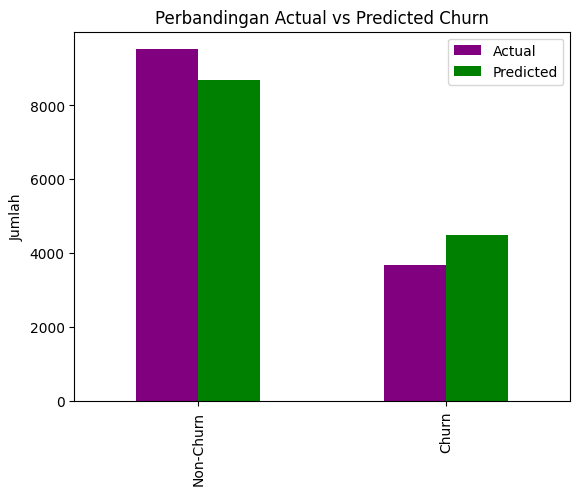

In [ ]:
import numpy as np

actual_counts = y_test.value_counts()
predicted_counts = pd.Series(y_pred).value_counts()

df_counts = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts})
df_counts.index = ['Non-Churn', 'Churn']
df_counts.plot(kind='bar', color=['purple', 'green'])
plt.ylabel("Jumlah")
plt.title("Perbandingan Actual vs Predicted Churn")
plt.show()

## Mencoba dengan data baru

In [ ]:
test_data.info()

test_data.describe()

test_data['Cancelled'] = test_data['Invoice'].apply(lambda x: 1 if str(x).startswith('C') else 0)
print(f"Proportion of cancelled transactions: {test_data['Cancelled'].mean() * 100:.2f}%")

cancelled_per_customer = test_data.groupby('Customer ID')['Cancelled'].sum()

test_data['TotalCancelled'] = test_data['Customer ID'].map(cancelled_per_customer)

<class 'pandas.core.frame.DataFrame'>
Index: 31402 entries, 95203 to 126604
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Invoice      31402 non-null  object        
 1   StockCode    31402 non-null  object        
 2   Description  31292 non-null  object        
 3   Quantity     31402 non-null  int64         
 4   InvoiceDate  31402 non-null  datetime64[ns]
 5   Price        31402 non-null  float64       
 6   Customer ID  25376 non-null  float64       
 7   Country      31402 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 2.2+ MB
Proportion of cancelled transactions: 1.77%


In [ ]:
test_data.dropna(inplace=True)
print(f"test_data shape after dropping nulls: {test_data.shape}")

test_data shape after dropping nulls: (25376, 10)


In [ ]:
test_data['TotalPrice'] = test_data['Quantity'] * test_data['Price']

test_data['InvoiceDate'] = pd.to_datetime(test_data['InvoiceDate'])

test_data['InvoiceMonth'] = test_data['InvoiceDate'].dt.month

Boxplot Sebelum Menghapus Outliers:


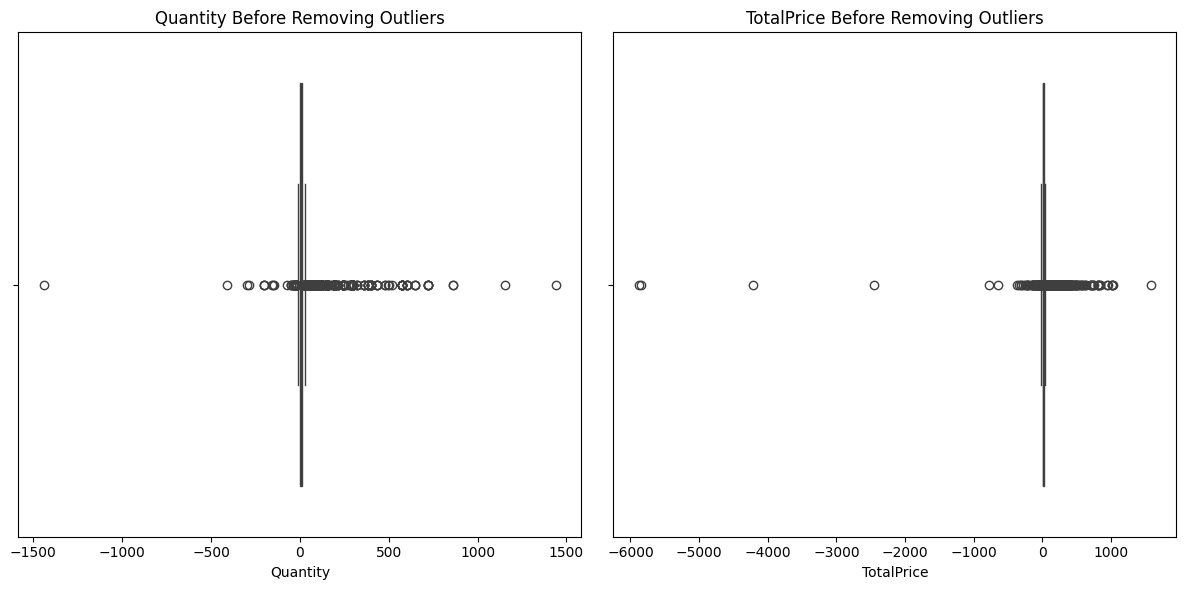

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplot(data, column, ax, title):
    sns.boxplot(x=data[column], ax=ax)
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

print("Boxplot Sebelum Menghapus Outliers:")
plot_boxplot(test_data, 'Quantity', axes[0], 'Quantity Before Removing Outliers')
plot_boxplot(test_data, 'TotalPrice', axes[1], 'TotalPrice Before Removing Outliers')

plt.tight_layout()
plt.show()

In [ ]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

test_data = remove_outliers(test_data, 'Quantity')
test_data = remove_outliers(test_data, 'TotalPrice')
print(f"test_data shape after removing outliers: {test_data.shape}")

test_data shape after removing outliers: (22413, 12)


Boxplot Setelah Menghapus Outliers:


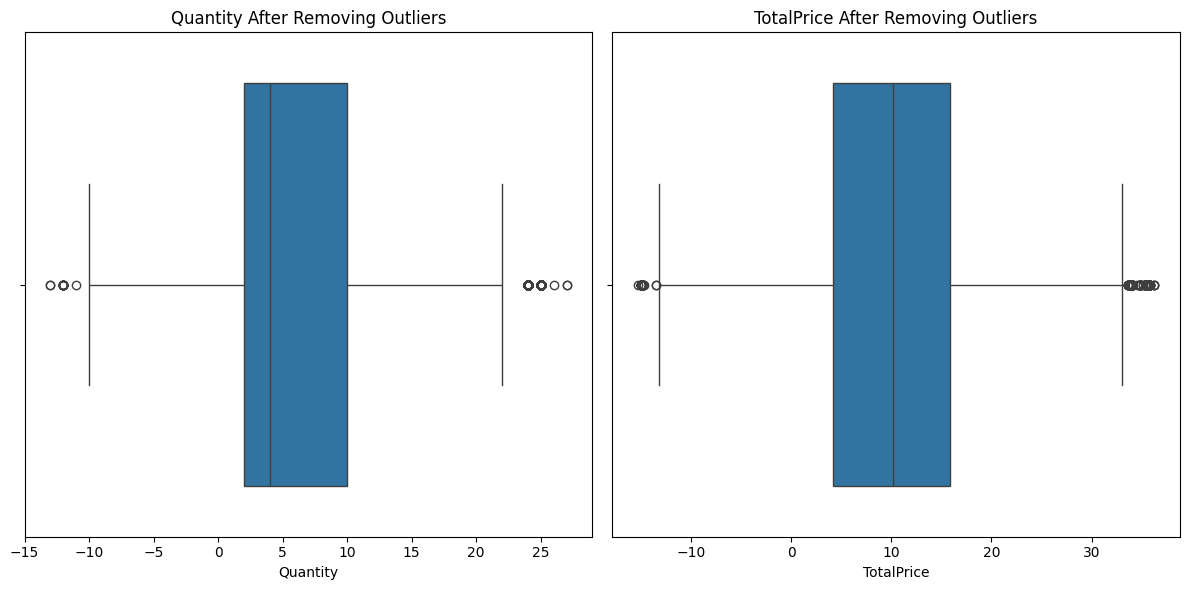

In [ ]:
print("Boxplot Setelah Menghapus Outliers:")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_boxplot(test_data, 'Quantity', axes[0], 'Quantity After Removing Outliers')
plot_boxplot(test_data, 'TotalPrice', axes[1], 'TotalPrice After Removing Outliers')
plt.tight_layout()
plt.show()

In [ ]:
last_invoice_date = test_data['InvoiceDate'].max()
churn_threshold_date = last_invoice_date - pd.DateOffset(months=6)

churn_customers = test_data.groupby('Customer ID')['InvoiceDate'].max()
test_data['Churn'] = test_data['Customer ID'].apply(lambda x: 1 if churn_customers[x] < churn_threshold_date else 0)

In [ ]:
test_data

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Cancelled,TotalCancelled,TotalPrice,InvoiceMonth,Churn
95210,503430,84327A,PINK JUMPER LARRY THE LAMB,6,2010-04-01 07:49:00,2.10,13361.0,United Kingdom,0,0.0,12.60,4,0
95211,503430,84508C,BLUE CIRCLES DESIGN TEDDY,6,2010-04-01 07:49:00,2.55,13361.0,United Kingdom,0,0.0,15.30,4,0
95212,503430,22114,HOT WATER BOTTLE TEA AND SYMPATHY,4,2010-04-01 07:49:00,3.95,13361.0,United Kingdom,0,0.0,15.80,4,0
95213,503430,22112,CHOCOLATE HOT WATER BOTTLE,3,2010-04-01 07:49:00,4.95,13361.0,United Kingdom,0,0.0,14.85,4,0
95214,503430,20702,PINK PADDED MOBILE,3,2010-04-01 07:49:00,4.25,13361.0,United Kingdom,0,0.0,12.75,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
126600,506673,22551,PLASTERS IN TIN SPACEBOY,1,2010-04-30 17:33:00,1.65,17602.0,United Kingdom,0,0.0,1.65,4,0
126601,506673,22556,PLASTERS IN TIN CIRCUS PARADE,3,2010-04-30 17:33:00,1.65,17602.0,United Kingdom,0,0.0,4.95,4,0
126602,506673,22554,PLASTERS IN TIN WOODLAND ANIMALS,3,2010-04-30 17:33:00,1.65,17602.0,United Kingdom,0,0.0,4.95,4,0
126603,506673,22553,PLASTERS IN TIN SKULLS,3,2010-04-30 17:33:00,1.65,17602.0,United Kingdom,0,0.0,4.95,4,0


In [ ]:
y_pred = rf_model.predict(test_data[features])

In [ ]:
import pandas as pd

y_pred = rf_model.predict(test_data[features])

result = test_data[['Customer ID']].copy()
result['Prediction'] = y_pred

result

,Customer ID,Prediction
95210,13361.0,0
95211,13361.0,0
95212,13361.0,0
95213,13361.0,0
95214,13361.0,0
...,...,...
126600,17602.0,0
126601,17602.0,0
126602,17602.0,0
126603,17602.0,0
